# Transformers: Attention Is All You Need

## What are Transformers?

Transformers are a neural network architecture that has revolutionized natural language processing and beyond. Introduced in the paper "Attention Is All You Need" (Vaswani et al., 2017), Transformers rely entirely on attention mechanisms, dispensing with recurrence and convolutions.

### Key Innovations:

1. **Self-Attention**: Allow each position to attend to all positions in the input
2. **Multi-Head Attention**: Multiple attention mechanisms running in parallel
3. **Positional Encoding**: Inject information about position since there's no recurrence
4. **Layer Normalization**: Stabilize training of deep networks
5. **Feed-Forward Networks**: Point-wise transformations

### Architecture Components:

1. **Encoder**: Stack of identical layers (self-attention + FFN)
2. **Decoder**: Stack of identical layers (masked self-attention + encoder-decoder attention + FFN)
3. **Attention Mechanism**: Scaled dot-product attention
4. **Position Embeddings**: Sinusoidal or learned positional encodings

### Applications:
- Machine Translation
- Text Summarization
- Question Answering
- Language Modeling (GPT)
- Computer Vision (Vision Transformer)
- Protein Folding (AlphaFold)

In this tutorial, we'll implement a Transformer from scratch and apply it to language modeling tasks.

In [1]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import math
import copy
import time
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


## Understanding Attention Mechanism

Let's start by understanding the core attention mechanism

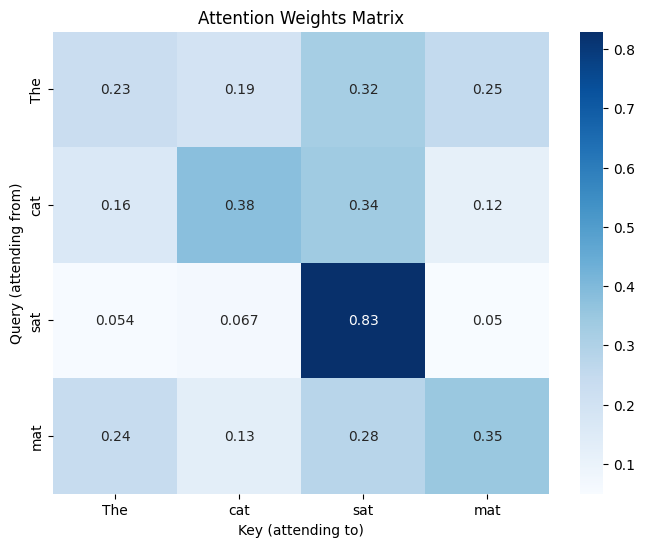

Input shape: torch.Size([1, 4, 3])
Output shape: torch.Size([1, 4, 3])
Attention weights shape: torch.Size([1, 4, 4])


In [2]:
def scaled_dot_product_attention(query, key, value, mask=None, dropout=None):
    """
    Compute scaled dot product attention.
    
    Attention(Q, K, V) = softmax(QK^T / sqrt(d_k))V
    
    Args:
        query: (batch_size, seq_len, d_k)
        key: (batch_size, seq_len, d_k)
        value: (batch_size, seq_len, d_v)
        mask: Optional mask to prevent attention to certain positions
        dropout: Optional dropout layer
    
    Returns:
        output: (batch_size, seq_len, d_v)
        attention_weights: (batch_size, seq_len, seq_len)
    """
    d_k = query.size(-1)
    
    # Compute attention scores
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)
    
    # Apply mask if provided (set masked positions to large negative value)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    
    # Apply softmax
    attention_weights = F.softmax(scores, dim=-1)
    
    # Apply dropout if provided
    if dropout is not None:
        attention_weights = dropout(attention_weights)
    
    # Apply attention to values
    output = torch.matmul(attention_weights, value)
    
    return output, attention_weights

# Visualize attention mechanism
def visualize_attention():
    """Visualize how attention works with a simple example"""
    
    # Simple example: 4 words, 3-dimensional embeddings
    seq_len, d_model = 4, 3
    
    # Random embeddings for "The cat sat mat"
    embeddings = torch.randn(1, seq_len, d_model)
    
    # For simplicity, use same embeddings for Q, K, V
    query = key = value = embeddings
    
    # Compute attention
    output, attention_weights = scaled_dot_product_attention(query, key, value)
    
    # Visualize attention matrix
    words = ['The', 'cat', 'sat', 'mat']
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(attention_weights[0].detach().numpy(), 
                xticklabels=words, yticklabels=words,
                annot=True, cmap='Blues', cbar=True)
    plt.title('Attention Weights Matrix')
    plt.xlabel('Key (attending to)')
    plt.ylabel('Query (attending from)')
    plt.show()
    
    print(f"Input shape: {embeddings.shape}")
    print(f"Output shape: {output.shape}")
    print(f"Attention weights shape: {attention_weights.shape}")

visualize_attention()

## Multi-Head Attention

Multi-head attention allows the model to attend to information from different representation subspaces

In [3]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_heads, dropout=0.1):
        super(MultiHeadAttention, self).__init__()
        assert d_model % n_heads == 0
        
        self.d_model = d_model
        self.n_heads = n_heads
        self.d_k = d_model // n_heads
        
        # Linear projections for Q, K, V
        self.w_q = nn.Linear(d_model, d_model)
        self.w_k = nn.Linear(d_model, d_model)
        self.w_v = nn.Linear(d_model, d_model)
        self.w_o = nn.Linear(d_model, d_model)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, query, key, value, mask=None):
        batch_size = query.size(0)
        
        # 1. Linear projections
        Q = self.w_q(query)  # (batch_size, seq_len, d_model)
        K = self.w_k(key)
        V = self.w_v(value)
        
        # 2. Split into multiple heads
        Q = Q.view(batch_size, -1, self.n_heads, self.d_k).transpose(1, 2)
        K = K.view(batch_size, -1, self.n_heads, self.d_k).transpose(1, 2)
        V = V.view(batch_size, -1, self.n_heads, self.d_k).transpose(1, 2)
        # Shape: (batch_size, n_heads, seq_len, d_k)
        
        # 3. Apply attention
        attention_output, attention_weights = scaled_dot_product_attention(
            Q, K, V, mask=mask, dropout=self.dropout
        )
        
        # 4. Concatenate heads
        attention_output = attention_output.transpose(1, 2).contiguous().view(
            batch_size, -1, self.d_model
        )
        
        # 5. Final linear projection
        output = self.w_o(attention_output)
        
        return output, attention_weights

# Test multi-head attention
d_model, n_heads = 512, 8
seq_len, batch_size = 10, 2

mha = MultiHeadAttention(d_model, n_heads)
x = torch.randn(batch_size, seq_len, d_model)

output, attention_weights = mha(x, x, x)
print(f"Input shape: {x.shape}")
print(f"Output shape: {output.shape}")
print(f"Attention weights shape: {attention_weights.shape}")
print(f"Number of parameters: {sum(p.numel() for p in mha.parameters()):,}")

Input shape: torch.Size([2, 10, 512])
Output shape: torch.Size([2, 10, 512])
Attention weights shape: torch.Size([2, 8, 10, 10])
Number of parameters: 1,050,624


## Positional Encoding

Since Transformers don't have inherent notion of position, we add positional encodings

TypeError: gca() got an unexpected keyword argument 'projection'

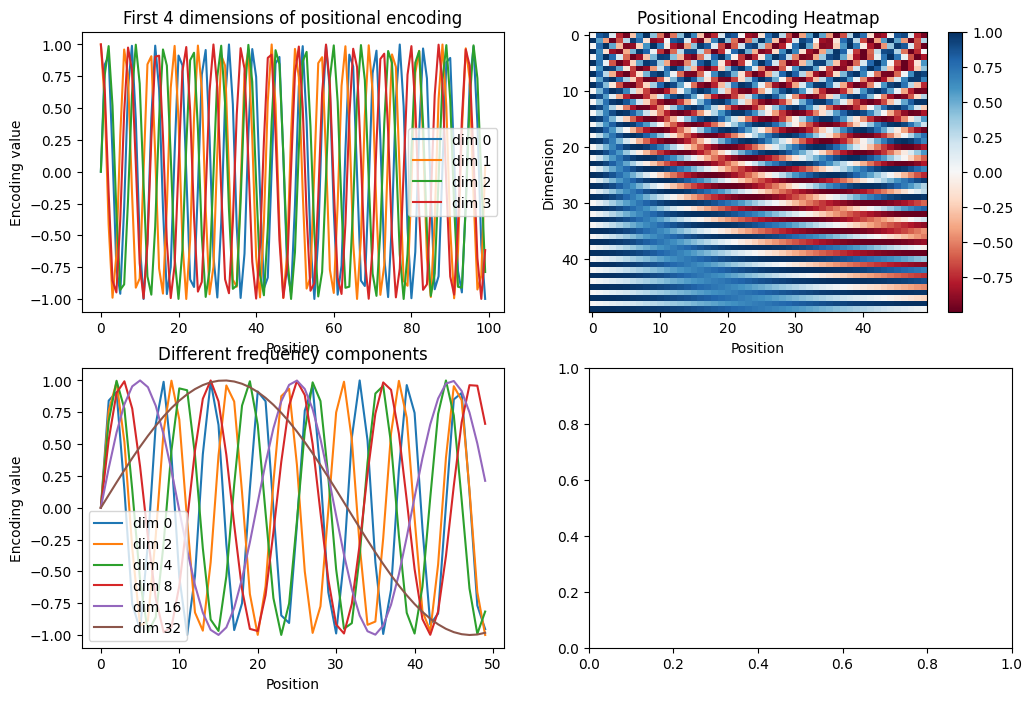

In [4]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_length=5000):
        super(PositionalEncoding, self).__init__()
        
        # Create positional encoding matrix
        pe = torch.zeros(max_seq_length, d_model)
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
        
        # Compute the div_term for sinusoidal encoding
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * 
                           (-math.log(10000.0) / d_model))
        
        # Apply sin to even indices
        pe[:, 0::2] = torch.sin(position * div_term)
        # Apply cos to odd indices
        pe[:, 1::2] = torch.cos(position * div_term)
        
        # Add batch dimension and register as buffer
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        # Add positional encoding to input embeddings
        seq_length = x.size(1)
        return x + self.pe[:, :seq_length, :]

# Visualize positional encodings
def visualize_positional_encoding():
    d_model = 128
    max_len = 100
    
    pe = PositionalEncoding(d_model, max_len)
    
    # Get the positional encoding matrix
    pos_encoding = pe.pe[0, :max_len, :].numpy()
    
    plt.figure(figsize=(12, 8))
    
    # Plot the first few dimensions
    plt.subplot(2, 2, 1)
    plt.plot(pos_encoding[:, :4])
    plt.title('First 4 dimensions of positional encoding')
    plt.xlabel('Position')
    plt.ylabel('Encoding value')
    plt.legend(['dim 0', 'dim 1', 'dim 2', 'dim 3'])
    
    # Heatmap of positional encodings
    plt.subplot(2, 2, 2)
    plt.imshow(pos_encoding[:50, :50].T, aspect='auto', cmap='RdBu')
    plt.title('Positional Encoding Heatmap')
    plt.xlabel('Position')
    plt.ylabel('Dimension')
    plt.colorbar()
    
    # Show how different frequencies evolve
    plt.subplot(2, 2, 3)
    dims_to_plot = [0, 2, 4, 8, 16, 32]
    for dim in dims_to_plot:
        plt.plot(pos_encoding[:50, dim], label=f'dim {dim}')
    plt.title('Different frequency components')
    plt.xlabel('Position')
    plt.ylabel('Encoding value')
    plt.legend()
    
    # 3D visualization of a few dimensions
    plt.subplot(2, 2, 4)
    from mpl_toolkits.mplot3d import Axes3D
    ax = plt.gca(projection='3d')
    positions = np.arange(50)
    ax.plot(positions, pos_encoding[:50, 0], pos_encoding[:50, 1])
    ax.set_xlabel('Position')
    ax.set_ylabel('Dim 0')
    ax.set_zlabel('Dim 1')
    ax.set_title('3D view of first 2 dimensions')
    
    plt.tight_layout()
    plt.show()

visualize_positional_encoding()

## Feed-Forward Network

Each layer contains a position-wise feed-forward network

In [5]:
class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w1 = nn.Linear(d_model, d_ff)
        self.w2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        # FFN(x) = max(0, xW1 + b1)W2 + b2
        return self.w2(self.dropout(F.relu(self.w1(x))))

# Test feed-forward network
d_model, d_ff = 512, 2048
ffn = PositionwiseFeedForward(d_model, d_ff)

x = torch.randn(2, 10, d_model)
output = ffn(x)
print(f"Input shape: {x.shape}")
print(f"Output shape: {output.shape}")
print(f"FFN parameters: {sum(p.numel() for p in ffn.parameters()):,}")

Input shape: torch.Size([2, 10, 512])
Output shape: torch.Size([2, 10, 512])
FFN parameters: 2,099,712


## Transformer Encoder Layer

In [6]:
class TransformerEncoderLayer(nn.Module):
    def __init__(self, d_model, n_heads, d_ff, dropout=0.1):
        super(TransformerEncoderLayer, self).__init__()
        
        # Multi-head self-attention
        self.self_attention = MultiHeadAttention(d_model, n_heads, dropout)
        
        # Position-wise feed-forward
        self.feed_forward = PositionwiseFeedForward(d_model, d_ff, dropout)
        
        # Layer normalization
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        
        # Dropout
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, mask=None):
        # Self-attention with residual connection and layer norm
        attn_output, attention_weights = self.self_attention(x, x, x, mask)
        x = self.norm1(x + self.dropout(attn_output))
        
        # Feed-forward with residual connection and layer norm
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))
        
        return x, attention_weights

# Test encoder layer
encoder_layer = TransformerEncoderLayer(d_model=512, n_heads=8, d_ff=2048)
x = torch.randn(2, 10, 512)
output, attention = encoder_layer(x)

print(f"Encoder layer output shape: {output.shape}")
print(f"Attention weights shape: {attention.shape}")

Encoder layer output shape: torch.Size([2, 10, 512])
Attention weights shape: torch.Size([2, 8, 10, 10])


## Complete Transformer Model

In [7]:
class Transformer(nn.Module):
    def __init__(self, vocab_size, d_model=512, n_heads=8, n_layers=6, 
                 d_ff=2048, max_seq_length=5000, dropout=0.1):
        super(Transformer, self).__init__()
        
        self.d_model = d_model
        self.vocab_size = vocab_size
        
        # Token embeddings
        self.embedding = nn.Embedding(vocab_size, d_model)
        
        # Positional encoding
        self.pos_encoding = PositionalEncoding(d_model, max_seq_length)
        
        # Transformer encoder layers
        self.encoder_layers = nn.ModuleList([
            TransformerEncoderLayer(d_model, n_heads, d_ff, dropout)
            for _ in range(n_layers)
        ])
        
        # Output projection
        self.output_projection = nn.Linear(d_model, vocab_size)
        
        # Dropout
        self.dropout = nn.Dropout(dropout)
        
        # Initialize weights
        self.init_weights()
        
    def init_weights(self):
        """Initialize weights"""
        initrange = 0.1
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.output_projection.bias.data.zero_()
        self.output_projection.weight.data.uniform_(-initrange, initrange)
    
    def create_padding_mask(self, x, pad_token=0):
        """Create mask to ignore padding tokens"""
        return (x != pad_token).unsqueeze(1).unsqueeze(2)
    
    def forward(self, src, src_mask=None):
        # Token embeddings
        src_embed = self.embedding(src) * math.sqrt(self.d_model)
        
        # Add positional encoding
        src_embed = self.pos_encoding(src_embed)
        src_embed = self.dropout(src_embed)
        
        # Pass through encoder layers
        x = src_embed
        attention_weights = []
        
        for layer in self.encoder_layers:
            x, attn = layer(x, src_mask)
            attention_weights.append(attn)
        
        # Output projection
        output = self.output_projection(x)
        
        return output, attention_weights

# Create a small transformer for testing
vocab_size = 1000
model = Transformer(
    vocab_size=vocab_size, 
    d_model=256, 
    n_heads=8, 
    n_layers=4, 
    d_ff=1024
).to(device)

print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

# Test forward pass
batch_size, seq_len = 2, 20
src = torch.randint(0, vocab_size, (batch_size, seq_len)).to(device)
output, attention_weights = model(src)

print(f"Input shape: {src.shape}")
print(f"Output shape: {output.shape}")
print(f"Number of attention layers: {len(attention_weights)}")
print(f"Attention shape per layer: {attention_weights[0].shape}")

Model parameters: 3,672,040
Input shape: torch.Size([2, 20])
Output shape: torch.Size([2, 20, 1000])
Number of attention layers: 4
Attention shape per layer: torch.Size([2, 8, 20, 20])


## Creating a Simple Language Dataset

Let's create a simple character-level language modeling dataset

In [8]:
class CharDataset(Dataset):
    def __init__(self, text, seq_length):
        self.seq_length = seq_length
        
        # Create character vocabulary
        chars = sorted(list(set(text)))
        self.vocab_size = len(chars)
        
        # Character to index and index to character mappings
        self.char_to_idx = {ch: i for i, ch in enumerate(chars)}
        self.idx_to_char = {i: ch for i, ch in enumerate(chars)}
        
        # Convert text to indices
        self.data = [self.char_to_idx[ch] for ch in text]
        
    def __len__(self):
        return len(self.data) - self.seq_length
    
    def __getitem__(self, idx):
        # Return sequence and target (next character)
        x = torch.tensor(self.data[idx:idx + self.seq_length], dtype=torch.long)
        y = torch.tensor(self.data[idx + 1:idx + self.seq_length + 1], dtype=torch.long)
        return x, y

# Create a simple text dataset
sample_text = """
The Transformer architecture has revolutionized natural language processing.
It uses self-attention mechanisms to process sequences in parallel.
This allows for more efficient training compared to recurrent neural networks.
The key innovation is the attention mechanism that allows each position to attend to all positions.
This has led to breakthrough models like BERT, GPT, and T5.
These models have achieved state-of-the-art results on many NLP tasks.
""".strip()

# Create dataset
seq_length = 50
dataset = CharDataset(sample_text, seq_length)
# Set num_workers=0 for compatibility across platforms
dataloader = DataLoader(dataset, batch_size=8, shuffle=True, num_workers=0)

print(f"Text length: {len(sample_text)}")
print(f"Vocabulary size: {dataset.vocab_size}")
print(f"Number of samples: {len(dataset)}")
print(f"Characters: {''.join(dataset.idx_to_char[i] for i in range(min(20, dataset.vocab_size)))}...")

# Sample batch
x_sample, y_sample = next(iter(dataloader))
print(f"\nSample input shape: {x_sample.shape}")
print(f"Sample target shape: {y_sample.shape}")
print(f"Sample text: {''.join([dataset.idx_to_char[idx.item()] for idx in x_sample[0][:30]])}...")

Text length: 454
Vocabulary size: 39
Number of samples: 404
Characters: 
 ,-.5BEGILNPRTabcde...

Sample input shape: torch.Size([8, 50])
Sample target shape: torch.Size([8, 50])
Sample text: eakthrough models like BERT, G...


## Training the Transformer

In [9]:
# Create model for character-level language modeling
char_model = Transformer(
    vocab_size=dataset.vocab_size,
    d_model=128,
    n_heads=4,
    n_layers=3,
    d_ff=512,
    max_seq_length=seq_length,
    dropout=0.1
).to(device)

# Training setup
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(char_model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.8)

def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    
    for batch_idx, (data, target) in enumerate(dataloader):
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        
        # Forward pass
        output, _ = model(data)
        
        # Reshape for loss calculation
        output = output.view(-1, output.size(-1))
        target = target.view(-1)
        
        loss = criterion(output, target)
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        optimizer.step()
        total_loss += loss.item()
    
    return total_loss / len(dataloader)

def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    
    with torch.no_grad():
        for data, target in dataloader:
            data, target = data.to(device), target.to(device)
            output, _ = model(data)
            
            output = output.view(-1, output.size(-1))
            target = target.view(-1)
            
            loss = criterion(output, target)
            total_loss += loss.item()
    
    return total_loss / len(dataloader)

# Training loop
num_epochs = 100
train_losses = []

print("Starting training...")
for epoch in range(num_epochs):
    train_loss = train_epoch(char_model, dataloader, criterion, optimizer, device)
    train_losses.append(train_loss)
    
    scheduler.step()
    
    if (epoch + 1) % 20 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {train_loss:.4f}, LR: {optimizer.param_groups[0]["lr"]:.6f}')

print("Training completed!")

Starting training...
Epoch 20/100, Loss: 0.0598, LR: 0.001000
Epoch 40/100, Loss: 0.0275, LR: 0.001000
Epoch 60/100, Loss: 0.0154, LR: 0.000800
Epoch 80/100, Loss: 0.0120, LR: 0.000800
Epoch 100/100, Loss: 0.0131, LR: 0.000640
Training completed!


## Text Generation with the Trained Model

In [10]:
def generate_text(model, dataset, start_text="The ", max_length=200, temperature=1.0):
    """Generate text using the trained model"""
    model.eval()
    
    # Convert start text to indices
    current_seq = [dataset.char_to_idx.get(ch, 0) for ch in start_text]
    generated_text = start_text
    
    with torch.no_grad():
        for _ in range(max_length):
            # Prepare input (take last seq_length characters)
            if len(current_seq) > seq_length:
                input_seq = current_seq[-seq_length:]
            else:
                input_seq = current_seq + [0] * (seq_length - len(current_seq))
            
            input_tensor = torch.tensor([input_seq], dtype=torch.long).to(device)
            
            # Get model prediction
            output, _ = model(input_tensor)
            
            # Get last time step output
            last_output = output[0, len(current_seq) - 1 if len(current_seq) <= seq_length else -1, :]
            
            # Apply temperature
            if temperature != 1.0:
                last_output = last_output / temperature
            
            # Sample from the distribution
            probabilities = F.softmax(last_output, dim=-1)
            next_char_idx = torch.multinomial(probabilities, 1).item()
            
            # Convert to character and add to sequence
            next_char = dataset.idx_to_char[next_char_idx]
            generated_text += next_char
            current_seq.append(next_char_idx)
    
    return generated_text

# Generate text with different temperatures
print("Generated text samples:")
print("=" * 50)

for temp in [0.5, 1.0, 1.5]:
    print(f"\nTemperature {temp}:")
    generated = generate_text(char_model, dataset, "The Transformer ", max_length=150, temperature=temp)
    print(generated)
    print("-" * 50)

Generated text samples:

Temperature 0.5:
The Transformer NLPT, s s.
Thes.
Thes.
The mehehehe models have achieved state-of-the-art results on many NLP tasks.
The mough models like BERT, GPT, and T5.
These mo
--------------------------------------------------

Temperature 1.0:
The Transformer mohoheses.
The .
Thes.
The ke .
The key innovation is the attention mechanism that allows each position to attend to all positions.
This has led to br
--------------------------------------------------

Temperature 1.5:
The Transformer mohes.
The kes.
The ke morkmoNLPTheas he more mough mough models like BERT, GPT, and modee models have achieved stat red d te-the-art results od T5.
T
--------------------------------------------------


## Visualizing Attention Patterns

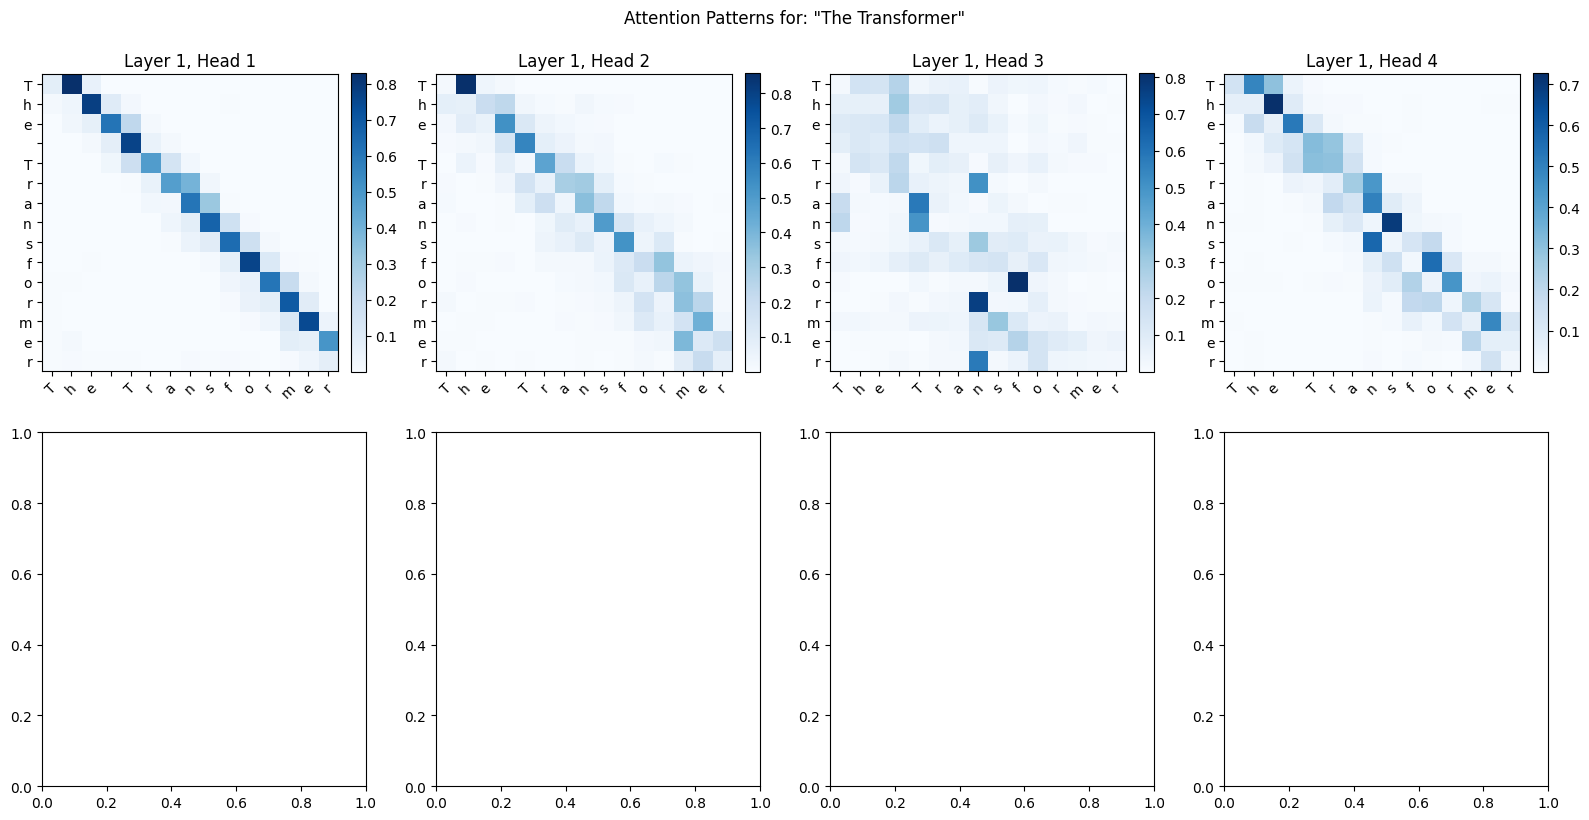

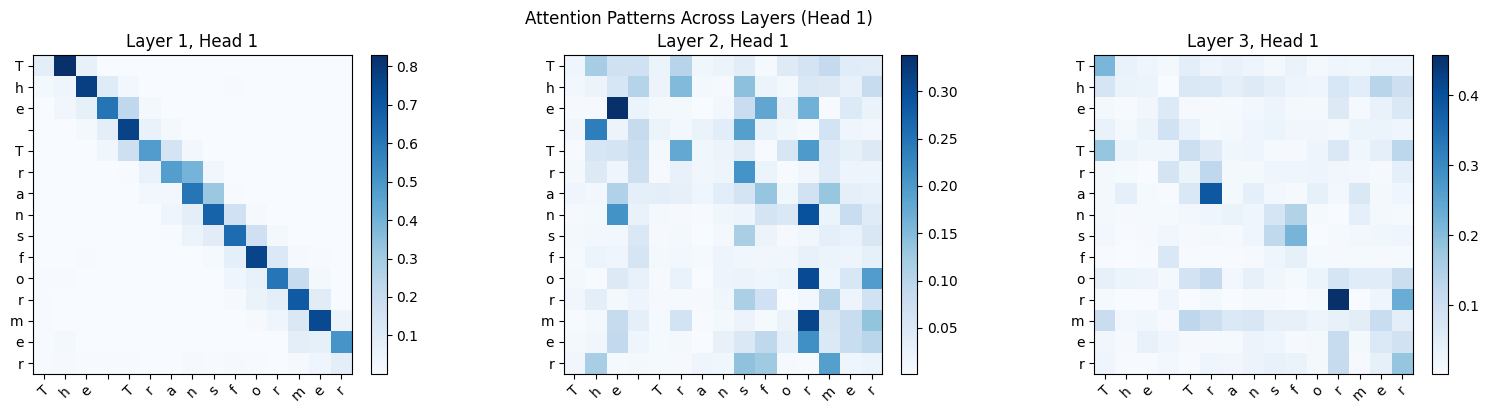

In [11]:
def visualize_attention_patterns(model, dataset, text="The Transformer architecture"):
    """Visualize attention patterns for a given text"""
    model.eval()
    
    # Convert text to indices
    indices = [dataset.char_to_idx.get(ch, 0) for ch in text]
    
    # Pad if necessary
    if len(indices) < seq_length:
        indices = indices + [0] * (seq_length - len(indices))
    else:
        indices = indices[:seq_length]
    
    input_tensor = torch.tensor([indices], dtype=torch.long).to(device)
    
    with torch.no_grad():
        _, attention_weights = model(input_tensor)
    
    # Visualize attention for each layer and head
    n_layers = len(attention_weights)
    n_heads = attention_weights[0].shape[1]
    
    # Plot attention for first layer, multiple heads
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    
    text_len = len(text)
    chars = list(text)
    
    for head in range(min(8, n_heads)):
        row = head // 4
        col = head % 4
        
        # Get attention weights for this head
        attn = attention_weights[0][0, head, :text_len, :text_len].cpu().numpy()
        
        # Plot heatmap
        im = axes[row, col].imshow(attn, cmap='Blues')
        axes[row, col].set_title(f'Layer 1, Head {head + 1}')
        axes[row, col].set_xticks(range(text_len))
        axes[row, col].set_yticks(range(text_len))
        axes[row, col].set_xticklabels(chars, rotation=45)
        axes[row, col].set_yticklabels(chars)
        
        # Add colorbar
        plt.colorbar(im, ax=axes[row, col], fraction=0.046, pad=0.04)
    
    plt.tight_layout()
    plt.suptitle(f'Attention Patterns for: "{text}"', y=1.02)
    plt.show()
    
    # Plot attention across layers for one head
    fig, axes = plt.subplots(1, min(4, n_layers), figsize=(16, 4))
    if n_layers == 1:
        axes = [axes]
    
    for layer in range(min(4, n_layers)):
        attn = attention_weights[layer][0, 0, :text_len, :text_len].cpu().numpy()
        
        im = axes[layer].imshow(attn, cmap='Blues')
        axes[layer].set_title(f'Layer {layer + 1}, Head 1')
        axes[layer].set_xticks(range(text_len))
        axes[layer].set_yticks(range(text_len))
        axes[layer].set_xticklabels(chars, rotation=45)
        axes[layer].set_yticklabels(chars)
        
        plt.colorbar(im, ax=axes[layer], fraction=0.046, pad=0.04)
    
    plt.tight_layout()
    plt.suptitle('Attention Patterns Across Layers (Head 1)', y=1.02)
    plt.show()

# Visualize attention patterns
visualize_attention_patterns(char_model, dataset, "The Transformer")

## Training Progress Visualization

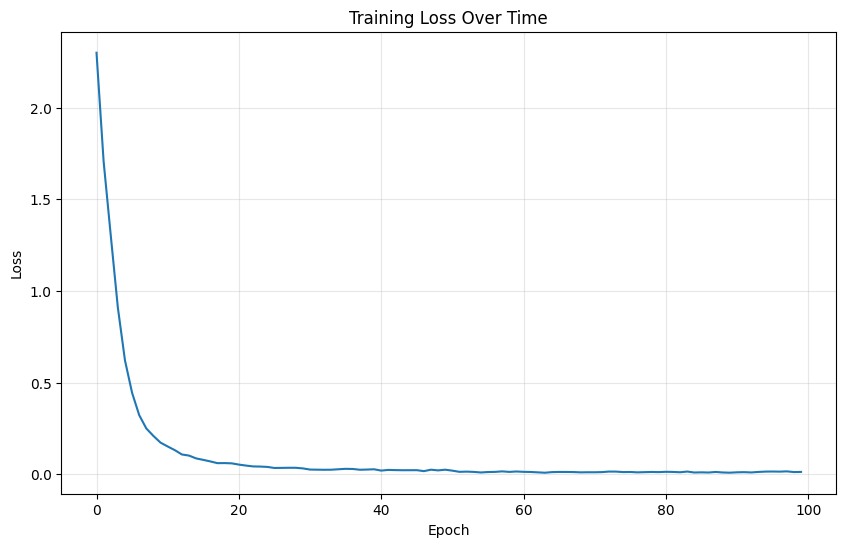

Final loss: 0.0131
Perplexity: 1.01


In [12]:
# Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses)
plt.title('Training Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True, alpha=0.3)
plt.show()

# Calculate perplexity
final_loss = train_losses[-1]
perplexity = math.exp(final_loss)
print(f"Final loss: {final_loss:.4f}")
print(f"Perplexity: {perplexity:.2f}")

## Advanced Transformer Concepts

In [13]:
# Demonstrate different attention patterns
def analyze_attention_heads(model, dataset):
    """Analyze what different attention heads learn"""
    model.eval()
    
    # Test sentence
    test_text = "attention mechanisms"
    indices = [dataset.char_to_idx.get(ch, 0) for ch in test_text]
    
    if len(indices) < seq_length:
        indices = indices + [0] * (seq_length - len(indices))
    else:
        indices = indices[:seq_length]
    
    input_tensor = torch.tensor([indices], dtype=torch.long).to(device)
    
    with torch.no_grad():
        _, attention_weights = model(input_tensor)
    
    # Analyze attention patterns
    text_len = len(test_text)
    first_layer_attn = attention_weights[0][0, :, :text_len, :text_len].cpu().numpy()
    
    # Compute attention statistics
    print("Attention Head Analysis:")
    print("=" * 40)
    
    for head in range(first_layer_attn.shape[0]):
        attn_matrix = first_layer_attn[head]
        
        # Compute entropy (how diffuse the attention is)
        entropy = -np.sum(attn_matrix * np.log(attn_matrix + 1e-10), axis=1).mean()
        
        # Compute self-attention (diagonal elements)
        self_attn = np.mean(np.diag(attn_matrix))
        
        # Compute local vs global attention
        local_attn = np.mean([attn_matrix[i, max(0, i-1):min(text_len, i+2)].sum() 
                             for i in range(text_len)])
        
        print(f"Head {head + 1}:")
        print(f"  Entropy: {entropy:.3f} (higher = more diffuse)")
        print(f"  Self-attention: {self_attn:.3f}")
        print(f"  Local attention: {local_attn:.3f}")
        print()

analyze_attention_heads(char_model, dataset)

Attention Head Analysis:
Head 1:
  Entropy: 0.963 (higher = more diffuse)
  Self-attention: 0.066
  Local attention: 0.713

Head 2:
  Entropy: 1.603 (higher = more diffuse)
  Self-attention: 0.077
  Local attention: 0.479

Head 3:
  Entropy: 2.197 (higher = more diffuse)
  Self-attention: 0.066
  Local attention: 0.301

Head 4:
  Entropy: 1.445 (higher = more diffuse)
  Self-attention: 0.064
  Local attention: 0.660



## Exercises

Now it's your turn to experiment with Transformers! Try these exercises:

### Exercise 1: Implement GPT-style Decoder
Modify the Transformer to use masked self-attention for autoregressive generation

In [ ]:
# Exercise 1: GPT-style Transformer
def create_causal_mask(seq_len):
    """Create causal mask for autoregressive generation"""
    # TODO: Implement causal mask
    # Should be lower triangular matrix
    pass

class GPTTransformer(nn.Module):
    def __init__(self, vocab_size, d_model=512, n_heads=8, n_layers=6, 
                 d_ff=2048, max_seq_length=1024, dropout=0.1):
        super(GPTTransformer, self).__init__()
        # TODO: Implement GPT-style architecture
        # Use causal masking in self-attention
        pass
    
    def forward(self, x):
        # TODO: Apply causal masking
        pass

# Compare with regular Transformer

### Exercise 2: Implement BERT-style Bidirectional Encoder
Create a BERT-like model with masked language modeling

In [ ]:
# Exercise 2: BERT-style Transformer
class BERTTransformer(nn.Module):
    def __init__(self, vocab_size, d_model=768, n_heads=12, n_layers=12):
        super(BERTTransformer, self).__init__()
        # TODO: Implement BERT architecture
        # Add special tokens [CLS], [SEP], [MASK]
        # Implement segment embeddings
        pass
    
    def masked_language_modeling_loss(self, predictions, targets, mask):
        # TODO: Compute MLM loss only on masked positions
        pass

# Implement masked language modeling training

### Exercise 3: Vision Transformer (ViT)
Apply Transformer architecture to image classification

In [ ]:
# Exercise 3: Vision Transformer
class PatchEmbedding(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_channels=3, embed_dim=768):
        super(PatchEmbedding, self).__init__()
        # TODO: Implement patch embedding
        # Split image into patches and linearly embed them
        pass

class VisionTransformer(nn.Module):
    def __init__(self, img_size=224, patch_size=16, num_classes=1000, 
                 embed_dim=768, n_layers=12, n_heads=12):
        super(VisionTransformer, self).__init__()
        # TODO: Implement Vision Transformer
        # Add CLS token, patch embeddings, classification head
        pass

# Test on CIFAR-10 or MNIST

### Exercise 4: Transformer with Relative Position Encoding
Implement relative positional encoding instead of absolute

In [ ]:
# Exercise 4: Relative Position Encoding
class RelativePositionEncoding(nn.Module):
    def __init__(self, d_model, max_relative_position=32):
        super(RelativePositionEncoding, self).__init__()
        # TODO: Implement relative position encoding
        # Store relative position embeddings
        pass
    
    def forward(self, seq_len):
        # TODO: Generate relative position matrix
        pass

class MultiHeadAttentionWithRelativePos(nn.Module):
    def __init__(self, d_model, n_heads, max_relative_position=32):
        super(MultiHeadAttentionWithRelativePos, self).__init__()
        # TODO: Modify attention to use relative positions
        pass

# Compare with absolute positional encoding

## Summary

In this tutorial, we've covered:

1. **Attention Mechanism**: Scaled dot-product attention and its visualization
2. **Multi-Head Attention**: Parallel attention mechanisms for different representation subspaces
3. **Positional Encoding**: Injecting positional information into the model
4. **Transformer Architecture**: Complete encoder-only Transformer implementation
5. **Training**: Character-level language modeling with attention visualization
6. **Text Generation**: Sampling strategies and temperature control

### Key Insights:

1. **Parallelization**: Unlike RNNs, Transformers can process all positions simultaneously
2. **Long-Range Dependencies**: Self-attention allows direct connections between distant positions
3. **Interpretability**: Attention weights provide insights into what the model focuses on
4. **Scalability**: Transformer architecture scales well with data and compute

### Transformer Variants:

- **BERT**: Bidirectional encoder for understanding tasks
- **GPT**: Autoregressive decoder for generation tasks
- **T5**: Text-to-text transfer transformer
- **Vision Transformer**: Applies Transformers to computer vision
- **DETR**: Detection Transformer for object detection

### Why Transformers Succeeded:

1. **Efficiency**: Parallelizable training
2. **Effectiveness**: Better at capturing long-range dependencies
3. **Transferability**: Pre-trained models transfer well to new tasks
4. **Scalability**: Performance improves with scale

Transformers have become the foundation of modern AI, powering everything from ChatGPT to image generation models. Understanding their architecture is crucial for anyone working in deep learning today!